## Robust Optimization of Single-Item Newsvendor Problem

In the single-item newsvendor problem, a seller is uncertain about the demand of a certain product and has to decide in advance how many units of the product he/she wishes to order. The uncertainty in demand induces a loss, either in unsold items or in unmet demand. Let $d_i$ be the realization of the demand in state $i$. Let $c$ be the cost of one unit of order, $v>c$ be the selling price, $s<c$ be the salvage value per unsold item returned to the order factory, and $l$ be the loss per unit of unmet demand. Denote $y$ to be the number of items ordered. The profit function $\pi(d_i,y)$ is defined as
\begin{align}
    \pi(d_i,y)&:=v\min\{d_i,y\}+s(y-d_i)_+-l(d_i-y)_+-cy\nonumber\\
    &= (s-v)(y-d_i)_+-l(d_i-y)_++(v-c)y.
\end{align}
Here, we assume that $d_i\in \{4,8,10\}$ with three possible realizations corresponding to low demand, medium demand, and high demand. The nominal probability of these realizations is assumed to be $\mathbf{p}=\{0.375,0.375,0.25\}$. We assume the number of items ordered will not exceed the maximal demand, i.e., $y\leq 10$. For the parameter values we take $v=6,l=4,s=2,c=4$

We assume the risk preference of the seller is represented by a risk measure induced by the distortion function $h_{cv}(x)=\min\{x/(1-\alpha_0),1\}$ and the seller's uncertainty in the probability $\mathbf{p}$ is measured by the Kullback-Leibler divergence function $\phi_{kl}(x)=x\log(x)-x+1$. This leads to the following robust optimization problem, where the worst case risk evaluation is minimized
\begin{align}
\min_{0\leq y\leq 10, t\in \mathbb{R}}\{t|\sup_{(\mathbf{q},\mathbf{\bar{q}})\in \mathcal{U}_{\phi_{kl},h_{cv}}}-\sum^3_{i=1}\bar{q}_i\pi(d_i,y)\leq t\},
\end{align}
where

\begin{align}
\begin{split}
   \mathcal{U}_{\phi_{kl},h_{cv}}=\{(\mathbf{q},\bar{\mathbf{q}})\in \mathbb{R}^{6}_{\geq 0}&: \sum^3_{i=1} q_i=1,~\sum^{3}_{i=1} \bar{q}_i=1,~\sum^3_{i=1}p_i\phi_{kl}(\frac{q_i}{p_i})-r\leq 0\\
    &\bar{q}_1\leq h_{cv}(q_1),~ \bar{q}_2\leq h_{cv}(q_2),~\bar{q}_3\leq h_{cv}(q_3)\\
    &\bar{q}_1+\bar{q}_2\leq h_{cv}(q_1+q_2),~ \bar{q}_1+\bar{q}_3\leq h_{cv}(q_1+q_3),\bar{q}_2+\bar{q}_3\leq h_{cv}(q_2+q_3)\}.
\end{split}
\end{align}


Using reformulation technique, this robust optimization problem is eqvuialent to the following convex problem with finitely many constraints
\begin{align}\label{newsvendor:robust}
    \begin{split}
      \min_{\substack{y\in[0,10]\\ t, \alpha,\beta, \nu_j\in \mathbb{R}\\ \gamma,\lambda_j\geq 0}}&~t\\
     \text{subject to}~
        &\alpha+\beta+\gamma r +\sum^3_{i=1}p_i\gamma \phi_{kl}^*\left(\frac{-\alpha+\sum_{j: i\in I_j}\nu_j}{\gamma}\right)+\sum^6_{j=1}\lambda_j(-h_{cv})^*\left(\frac{-\nu_j}{\lambda_j}\right)\leq t\\
        &-r(d_i,y)-\beta-\sum_{j:i\in I_j}\lambda_j\leq 0,~i=1,2,3,
    \end{split}
\end{align}
where $I_1,\ldots , I_6$ are the subsets of $\{1,\ldots,6\}$ that are not the empty set or the entire set. $\phi^*_{kl}$ and $h^*_{cv}$ are the convex conjugates of $\phi_{kl}$ and $h_{cv}$.


We can solve the above problem using CVXPY. First we import the necessary packages.

In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd
import mosek
import matplotlib.pyplot as plt
### importing the phi-divergence functions 
import phi_divergence as phi        
### importing the distortion functions
import distortion_function as hf    
import scipy.stats
from itertools import chain, combinations

The reformulated robust problem can be solved by defining the following functions

In [3]:
### This function makes all subsets given a number of indices.
def powerset(iterable):                     
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


 ### This function can solve the reformulated problem
def RC_newsvendor_riskmin(sets,p,d,r,par,par_news,phi_conj, h_conj):   
    N = len(p)
    M = len(sets)
    v = cp.Variable(M)
    lbda = cp.Variable(M, nonneg = True)
    y = cp.Variable(1, nonneg = True)
    alpha, beta, c = [cp.Variable(1), cp.Variable(1), cp.Variable(1)]
    gamma = cp.Variable(1,nonneg = True)
    [v_news, l_news, s_news, c_news] = par_news
    z = cp.Variable(M)
    t, z2 = [cp.Variable(N), cp.Variable(N)]
    s = cp.Variable(N)
    w2_phi = cp.Variable(N)
    l1 = (v_news+l_news-c_news)*y*(np.zeros(N)+1) - l_news*d
    l2 = (s_news-c_news)*y*(np.zeros(N)+1) + (v_news-s_news)*d
    constraints = [y<=np.max(d), z2 <= l1, z2 <= l2]
    for i in range(N):
        lbdasum = 0
        vsum = 0
        for j in range(M):
            if i in sets[j]:
                lbdasum = lbdasum + lbda[j]
                vsum = vsum + v[j]
        constraints.append(-z2[i] - lbdasum - beta <= 0)
        constraints.append(s[i] == -alpha + vsum)
    constraints = phi_conj(gamma,s,t,w2_phi,constraints)
    constraints = h_conj(lbda,v,z,par,constraints)
    constraints.append(alpha + beta + gamma * r  + cp.sum(z) + p@t <= c)
    obj = cp.Minimize(c)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(y.value, c.value)

To compare the robust solution to the nominal solution, we also solve the nominal problem, where the risk evaluation is minimized with respect to the nominal probability $\mathbf{p}$
\begin{align*}
    \min_{0\leq y\leq 10, t\in \mathbb{R}}\{t|\sup_{\mathbf{\bar{q}}\in M_h(\mathbf{p})}-\sum^3_{i=1}\bar{q}_i\pi(d_i,y)\leq t\},
\end{align*}
where 
\begin{align*}
    M_h(\mathbf{p})=\{\mathbf{\bar{q}}\in \mathbb{R}^3_{\geq 0}|~\sum^3_{i=1}\bar{q}_i=1, \sum_{k\in I_j}\bar{q}_k\leq h(\sum_{k\in I_j}p_k), I_1,\ldots,I_6.\}
\end{align*}
Since the set $M_h(\mathbf{p})$ consists of linear inequalities, the nominal problem can be easily reformulated to the following convex problem
\begin{align*}
 \min_{\substack{y\in[0,10]\\ t,\beta, \nu_j\in \mathbb{R}\\ \gamma,\lambda_j\geq 0}}&~t\\
     \text{subject to}~
        &\beta+ \sum_{j=1}^6\lambda_jh(\sum_{k\in I_j}p_k)\leq t\\
        &-r(d_i,y)-\beta-\sum_{j:i\in I_j}\lambda_j\leq 0,~i=1,2,3.   
\end{align*}

In [4]:
### This function can solve the nominal problem

def nominal_solve(sets,p,d,par,par_news, h_eva):
    N = len(p)
    M = len(sets)
    lbda = cp.Variable(M, nonneg = True)
    y = cp.Variable(1, nonneg = True)
    beta, c = [cp.Variable(1), cp.Variable(1)]
    [v_news, l_news, s_news, c_news] = par_news
    z2 = cp.Variable(N)
    l1 = (v_news+l_news-c_news)*y*(np.zeros(N)+1) - l_news*d
    l2 = (s_news-c_news)*y*(np.zeros(N)+1) + (v_news-s_news)*d
    constraints = [y<= np.max(d), z2 <= l1, z2 <= l2]
    h_jsum = 0
    for i in range(N):
        lbdasum = 0
        for j in range(M):
            if i in sets[j]:
                lbdasum = lbdasum + lbda[j]
        constraints.append(-z2[i] - lbdasum - beta <= 0)
    for j in range(M):
         h_jsum = h_jsum + lbda[j]*h_eva(np.sum(p[sets[j]]),par)
    constraints.append(beta  + h_jsum <= c)
    obj = cp.Minimize(c)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(y.value, c.value)

We perform the following experiment to compare the robust solution to the nominal solution. We choose a range of (fictitious) sample size $n= 10, 20,\ldots 200$. This sample size is purely artificial: we treat $\mathbf{p}$ as estimated from a sample of size $n$. We also examine a range of quantile levels $\alpha_0 = 0.4, 0.3, 0.2, 0.1$ for the distortion risk measure. For both the robust and the nominal solution, we compare their worst case risk evaluation. For the robust solution, the worst case risk evaluation is simply the objective value of the robust problem i.e. the worst case risk evaluation minimization problem. For the nominal solution, the worst case risk evaluation is the objective value of the robust problem evaluated in this solution, which can be calculated by the following function.

In [5]:
### This function compute the worst case risk evaluation given a solution y

def robustcheck_newsvendor(y,d,r,p,par,par_news,h_func, phi_func):
    N = len(p)
    x = np.zeros(N)
    [v_news, l_news, s_news, c_news] = par_news
    for i in range(N):
        x[i] = v_news*np.minimum(d[i],y)+s_news*np.maximum(y-d[i],0)-l_news*np.maximum(d[i]-y,0)-c_news*y
    rank = np.argsort(x)
    q_b = cp.Variable(N, nonneg = True)
    q = cp.Variable(N, nonneg=True)
    constraints = [cp.sum(q) == 1, cp.sum(q_b)==1]
    constraints = h_func(q_b,q,rank,par,constraints)
    constraints = phi_func(p,q,r,par,constraints)
    obj = cp.Maximize(-q_b.T @ x)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(prob.value,q_b.value,q.value)

def wc(y,d,r,p,par,par_news, phi_func, sets):
    N = len(p)
    M = len(sets)
    x = np.zeros(N)
    [v_news, l_news, s_news, c_news] = par_news
    for i in range(N):
        x[i] = v_news*np.minimum(d[i],y)+s_news*np.maximum(y-d[i],0)-l_news*np.maximum(d[i]-y,0)-c_news*y
    q_b = cp.Variable(N, nonneg = True)
    q = cp.Variable(N, nonneg=True)
    constraints = [cp.sum(q) == 1, cp.sum(q_b)==1]
    constraints = phi_func(p,q,r,par,constraints)
    for j in range(M):
        q_sum = 0
        qb_sum = 0
        for i in range(N):
            if i in sets[j]:
                q_sum = q_sum + q[i]
                qb_sum = qb_sum + q_b[i]
        h_cons = (1+par)*q_sum-par*(q_sum)**2
        constraints.append(qb_sum-h_cons <= 0)
    obj = cp.Maximize(-q_b.T @ x)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(prob.value,q_b.value,q.value)



Defining the parameter values of demands, nominal probability, costs, etc. 

In [6]:
d = np.array([4,8,10])
p = np.array([0.375,0.375,0.25])
### parameter values of [v,l,s,c]
par_news = np.array([6,4,2,4])    

Defining the phi-divergence conjugate function, which in this case is the conjugate of kullback-leibler divergence.

In [7]:
### the epigraph of the phi conjugate function
phi_conj = phi.kb_conj  
### the epigraph of the phi function
phi_func = phi.kb_cut   
### evaluation of the phi function
phi_eva = phi.kb_eva     
### phi''_kl(1), second derivative of kl_divergence function evaluated at 1, which is equal to 1.
### Note that this has to be calculated by hand, which is usually not hard.
phi_dot = 1   

### Number of realisations of the demand d, which determines the phi-divergence radius
m = len(d)

Similarly, we define the necessary variables for the distortion function

In [10]:
### the conjugate of the h function writte in its epigraph representation
h_conj = hf.h_cvar_conj   
### h_eva can be used when we need to evaluate the h function
h_eva = hf.h_cvar_eva   
### the epigraph of the h function
h_func = hf.h_cvar_cut 
### parameter of the h function, in the h_cv case, this is the quantile parameter
par = 0.1  

### making all the subsets of {1,...,m} except the empty set and the whole set.
psets = list(powerset(list(range(m))))   
for i in range(1,len(psets)):
    psets[i] = list(psets[i])
psets = psets[1:(len(psets)-1)]
sets = psets

The following code performs the experiment and output the graph of the worst case risk evaluation of the robust and the nominal solutions, with respect to the sample size $n$.

C:\Users\gjin\AppData\Local\Temp\ipykernel_2596\4155095990.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wcrisk_rob[i] = RC_newsvendor_riskmin(sets,p,d,r,par,par_news,phi_conj, h_conj)[1]
C:\Users\gjin\AppData\Local\Temp\ipykernel_2596\475701882.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = v_news*np.minimum(d[i],y)+s_news*np.maximum(y-d[i],0)-l_news*np.maximum(d[i]-y,0)-c_news*y
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


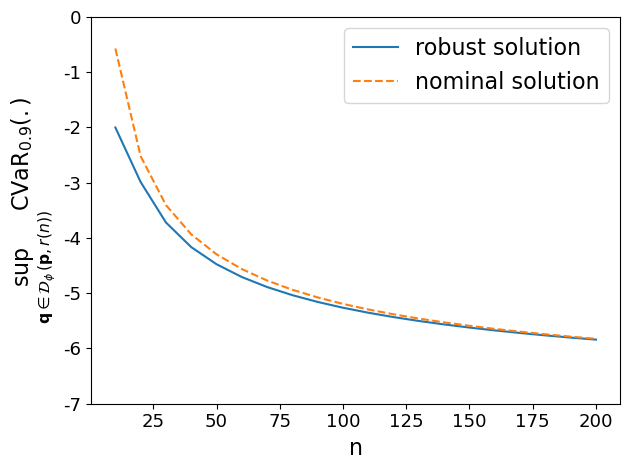

In [11]:
nsize = np.arange(10,210,10)
L = len(nsize)
wcrisk_rob = np.zeros(L)
wcrisk_nom = np.zeros(L)
for i in range(L):
    r = phi_dot/(2*nsize[i])*scipy.stats.chi2.ppf(0.95, m-1)
    wcrisk_rob[i] = RC_newsvendor_riskmin(sets,p,d,r,par,par_news,phi_conj, h_conj)[1]
    res_nom = nominal_solve(sets,p,d,par,par_news, h_eva)[0]
    wcrisk_nom[i] = robustcheck_newsvendor(res_nom,d,r,p,par,par_news,h_func, phi_func)[0]
plt.plot(nsize, wcrisk_rob, label = 'robust solution')
plt.plot(nsize, wcrisk_nom,'--', label = 'nominal solution')
plt.xlabel('n', fontsize = 16)
plt.ylabel(r'$\sup_{\mathbf{q}\in \mathcal{D}_{\phi}(\mathbf{p},r(n))}\mathrm{CVaR}_{0.9}(.)$', fontsize = 16)
plt.xticks(fontsize=13)  # Set font size for x-axis tick labels
y_min, y_max = plt.gca().get_ylim()
y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 1, 1)  # Ensure only integer ticks
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([int(tick) for tick in y_ticks], fontsize=13)


plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('s_news01.eps', format='eps')

In the second experiment, we compare the robust solution and the nominal solution by computing its risk evaluation with respect to a sample of probability vectors. We use the Hit-and-Run algorithm to sample 5000 probability vectors $\mathbf{q}$ in the $\phi$-divergence uncertainty set $\mathcal{D}_{\phi}(\mathbf{p},r)$ for $n=50$. For each sampled vector $\mathbf{q}$, we calculate the risk evaluation $\rho_{h_{cv},\mathbf{q}}$ for $\alpha_0=0.4$.

In [45]:
import Hit_and_Run as hr 

#### This function calculates the risk with respect to any probability vector

def nominal_risk(y,d,p,par,par_news, h_eva):   
    N = len(p)
    [v_news, l_news, s_news, c_news] = par_news
    x = np.zeros(N)
    for i in range(N):
        x[i] = v_news*np.minimum(d[i],y)+s_news*np.maximum(y-d[i],0)-l_news*np.maximum(d[i]-y,0)-c_news*y
    rank = np.argsort(x)
    q_b = np.zeros(N)
    q_b[rank[0]] = h_eva(p[rank[0]],par)
    risk = -q_b[rank[0]]*x[rank[0]]
    for i in range(1,N):
        q_b[rank[i]] = h_eva(np.sum(p[rank[0:i+1]]),par)-h_eva(np.sum(p[rank[0:i]]),par)
        risk = risk - q_b[rank[i]]*x[rank[i]]
    return(risk)

In [46]:
np.random.seed(10)
n = 50
r = phi_dot/(2*n)*scipy.stats.chi2.ppf(0.95, m-1)
### simulating the probability vectors in the phi-divergence uncertainty set
prob = hr.hit_and_run(p,phi.kb_eva,r,1,5000)  

The following code compute the robust solution and the nominal solution and calculate the risk of both solutions with respect to a sample of probability vectors.

In [47]:
### computing the robust solution
news_result = RC_newsvendor_riskmin(sets,p,d,r,par,par_news,phi_conj, h_conj)   
### Computing the nominal solution
news_nom_result = nominal_solve(sets,p,d,par,par_news, h_eva)  


l = len(prob)
risk_rob = np.zeros(l)
risk_nonrob = np.zeros(l)
for i in range(l):
    risk_rob[i] = nominal_risk(news_result[0],d,prob[i],par,par_news, h_eva)
    risk_nonrob[i] = nominal_risk(news_nom_result[0],d,prob[i],par,par_news, h_eva)

C:\Users\gjin\AppData\Local\Temp\ipykernel_19988\3558743789.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = v_news*np.minimum(d[i],y)+s_news*np.maximum(y-d[i],0)-l_news*np.maximum(d[i]-y,0)-c_news*y


Plotting the graph

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


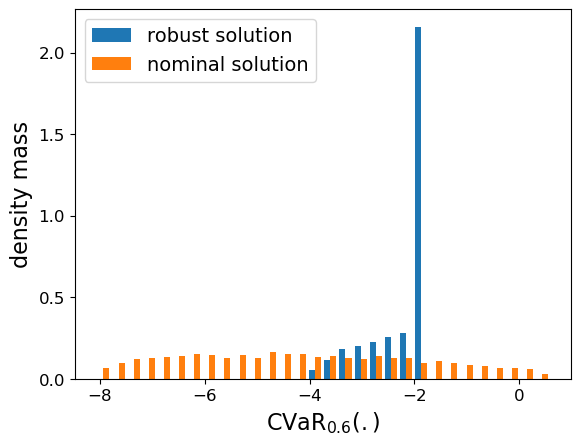

In [48]:
data1 = {'robust solution':risk_rob, 'nominal solution': risk_nonrob}
dt1 = pd.DataFrame(data = data1)
plt.hist(dt1,density = True, bins = 30)
plt.xlabel('$\mathrm{CVaR}_{0.6}(.)$',fontsize = 16)
plt.ylabel('density mass',fontsize = 16)
plt.xticks(fontsize=12)  # Set font size for x-axis tick labels
plt.yticks(fontsize=12)
plt.legend(dt1.columns,fontsize = 14)
plt.savefig('snews_cvar04.eps', format = 'eps',bbox_inches='tight')